# Activity recognition on the Capture24 dataset

Example using a random forest for activity recognition on the Capture24, using the hand-crafted features `X_feats`.
To account for the temporal dependency between instances, we also use a
hidden Markov model to smooth the predictions of the random forest.

To run this example, you will need [`scikit-learn`](https://scikit-learn.org/stable/index.html) and [`pandas`](https://pandas.pydata.org/).

###### Setup

In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import utils  # contains helper functions -- see utils.py

# For reproducibility
np.random.seed(42)

 ###### Load dataset and hold out some instances for testing 

In [2]:
X = np.load('capture24/X_feats.npy')
y = np.load('capture24/y_doherty.npy')  # Doherty et. al. 2018
time = np.load('capture24/time.npy')
pid = np.load('capture24/participant.npy')

# Leave out 10 participants for testing the model
pids_test = np.random.choice(np.unique(pid), size=10)
mask_test = np.isin(pid, pids_test)
mask_train = ~mask_test
X_train, y_train, pid_train, time_train = \
    X[mask_train], y[mask_train], pid[mask_train], time[mask_train]
X_test, y_test, pid_test, time_test = \
    X[mask_test], y[mask_test], pid[mask_test], time[mask_test]
print("Left-out participants:", pids_test)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Left-out participants: [113 103  16 117  77  22 113 146  81  95]
Shape of X_train: (349014, 125)
Shape of X_test: (20345, 125)


 ###### Train a random forest classifier

*Note: this takes a few minutes*

In [3]:
# Argument oob_score=True to be used for HMM smoothing (see below)
classifier = RandomForestClassifier(
    n_estimators=100, oob_score=True, n_jobs=4, verbose=True,
)
classifier.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  2.9min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
                       oob_score=True, random_state=None, verbose=True,
                       warm_start=False)

 ###### Evaluate model on held-out participants

We report a number of performance metrics on the left-out participants using the provided utility functions `utils.compute_scores` and `utils.print_scores`.

In [4]:
y_test_pred = classifier.predict(X_test)
print("\n--- Random forest performance ---")
utils.print_scores(utils.compute_scores(y_test, y_test_pred))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished



--- Random forest performance ---
Accuracy score: 0.7968051118210863
Balanced accuracy score: 0.5729718693691196
Cohen kappa score: 0.6810028064629263

Per-class recall scores:
sleep      : 0.9168413696715584
sedentary  : 0.857693743002861
tasks-light: 0.08201581027667984
walking    : 0.555978674790556
moderate   : 0.45232974910394264

Confusion matrix:
 [[7872  642    9   53   10]
 [ 820 6895   53  161  110]
 [  19  544   83  195  171]
 [   2  401   73  730  107]
 [   1  467  129  167  631]]


###### Plot predicted and true activity timeseries

Using the provided utility function `utils.plot_activity`,
we plot the activity timeseries for participant #113.
Here we also pass the first feature (first column of `X`) containing the mean
acceleration for plotting.

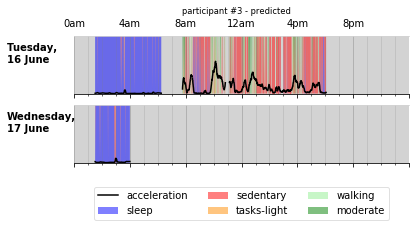

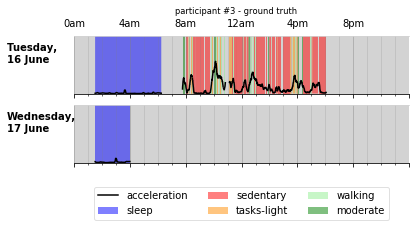

In [5]:
# Activity plot for participant #113 -- predicted
fig, _ = utils.plot_activity(
    X_test[pid_test==113][:,0],
    y_test_pred[pid_test==113],
    time_test[pid_test==113]
)
fig.suptitle('participant #3 - predicted', fontsize='small')
fig.show()

# Activity plot for participant #113 -- ground truth
fig, _ = utils.plot_activity(
    X_test[pid_test==113][:,0],
    y_test[pid_test==113],
    time_test[pid_test==113]
)
fig.suptitle('participant #3 - ground truth', fontsize='small')
fig.show()

###### Hidden Markov Model

To account for the temporal dependency between instances, we
apply a hidden Markov model (HMM) to smooth the random forest predictions.
In the following, we use our utility functions `utils.train_hmm` to estimate
the HMM matrices, and `utils.viterbi` to perform the smoothing:


--- Random forest performance with HMM smoothing ---
Accuracy score: 0.8504300811010076
Balanced accuracy score: 0.6177399049847874
Cohen kappa score: 0.7652127230165091

Per-class recall scores:
sleep      : 0.9620312136035406
sedentary  : 0.923124766762035
tasks-light: 0.029644268774703556
walking    : 0.5681645087585682
moderate   : 0.6057347670250897

Confusion matrix:
 [[8260  282    0   44    0]
 [ 428 7421    2  130   58]
 [   0  495   30  283  204]
 [   0  406   33  746  128]
 [   0  356   44  150  845]]


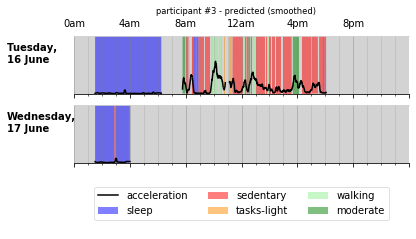

In [6]:
Y_oob = classifier.oob_decision_function_  # grab out-of-bag estimates
prior, emission, transition = utils.train_hmm(Y_oob, y_train)  # HMM training step
y_test_pred_hmm = utils.viterbi(y_test_pred, prior, emission, transition)  # smoothing
print("\n--- Random forest performance with HMM smoothing ---")
utils.print_scores(utils.compute_scores(y_test, y_test_pred_hmm))

# Activity plot for participant #113 -- predicted
fig, _ = utils.plot_activity(
    X_test[pid_test==113][:,0],
    y_test_pred_hmm[pid_test==113],
    time_test[pid_test==113]
)
fig.suptitle('participant #3 - predicted (smoothed)', fontsize='small')
fig.show()
